# Exercise: Temperature Control in a Greenhouse

**Objective:** To design and compare two control strategies for regulating the temperature inside a lettuce greenhouse: a simple **Heuristic Feedforward Controller** and an advanced **Nonlinear Model Predictive Controller (NMPC)**. The controllers should track temperature setpoints of 18°C during the day and 12°C in the evening.

**Context:** Greenhouses allow us to grow crops year-round, but maintaining the optimal temperature requires careful management of resources like heating and ventilation. The goal is to track the specified temperature setpoints to support healthy crop growth while considering operational constraints. 

## 1. Problem Formulation

### Model Description 
We will be working with a dynamic model of a greenhouse that simulates the growth of lettuce. The model is influenced by our control actions and external weather conditions (disturbances). An illustration of the greenhouse model is shown below.

<img src="https://raw.githubusercontent.com/xcheng20/Greenhouse_Control_Exercise/main/greenhouse_model.png" width=700>


In the figure, we have: 

The state of our system is described by four variables:
- **$x_1$**: Dry weight of the lettuce (kg/m²)
- **$x_2$**: Indoor CO₂ concentration (kg/m³)
- **$x_3$**: Indoor air temperature (°C)
- **$x_4$**: Indoor humidity (kg/m³)

We can influence the system using three control inputs:
- **$u_1$**: CO₂ injection rate (mg/m²/s)
- **$u_2$**: Ventilation rate (mm/s)
- **$u_3$**: Heating power (W/m²)

The system is also affected by four external disturbances (weather):
- **$d_1$**: Solar radiation (W/m²)
- **$d_2$**: Outdoor CO₂ concentration (ppm)
- **$d_3$**: Outdoor temperature (°C)
- **$d_4$**: Outdoor humidity (%)

Finally, for plotting and setting constraints, we observe four output variables from sensor measurements:
- **$y_1$**: Dry weight of the lettuce (g/m²) - *Note the unit change from state $x_1$*
- **$y_2$**: Indoor CO₂ concentration (ppm)
- **$y_3$**: Indoor air temperature (°C)
- **$y_4$**: Indoor relative humidity (%)

### Control Objective

Our primary goal is to **track the temperature setpoints ($y_3$)**: 18°C during the day (when solar radiation > 50 W/m²) and 12°C in the evening (when solar radiation ≤ 50 W/m²).

### Constraints

To ensure healthy crop growth, we must keep the greenhouse climate within certain bounds:
- **Temperature ($y_3$)**: Must be kept within a specific range (e.g., 6.5°C to 40°C).
- **Relative Humidity ($y_4$)**: Must not exceed a certain level to prevent mold (e.g., below 70%).
- **CO₂ ($y_2$)**: Must be kept within a healthy range for photosynthesis.

Our control inputs are also physically limited:
- CO₂ injection, ventilation, and heating cannot be negative.
- There are maximum limits on how much we can heat, ventilate, or inject CO₂.

## 2. Setup and Preliminaries

First, let's import the necessary libraries and define the model functions. 

Make sure you have `numpy`, `matplotlib`, `scipy`, and `casadi` installed. For the optimization problem, we will use CasADi, which is an open‐source framework designed for nonlinear optimization and optimal control that heavily relies on symbolic expressions and automatic differentiation, see the details and user manual at https://web.casadi.org/.


In [ ]:
###############################################################################
## Import necessary libraries, no need to edit
################################################################################ 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import signal
import statistics
import math
import casadi

Below are the necessary functions for unit conversion. You should run the following block for the latter calculations.

In [282]:
###############################################################################
## UNIT CONVERSION FUNCTIONS, Do NOT EDIT
###############################################################################

# Convert relative humidity to vapor density 
def rh2vaporDens(temp,rh):
    # constants
    R    = 8.3144598 # molar gas constant [J mol^{-1} K^{-1}]
    C2K  = 273.15 # conversion from Celsius to Kelvin [K]
    Mw   = 18.01528e-3 # molar mass of water [kg mol^-{1}]

    # parameters used in the conversion
    c       = np.array([610.78, 238.3, 17.2694, -6140.4, 273, 28.916])
    satP    = c[0]*np.exp(c[2]*np.divide(temp,(temp+c[1]))) 
    pascals = (rh/100)*satP # Partial pressure of vapor in air [Pa]
    vaporDens = np.divide(pascals*Mw,(R*(temp+C2K)))
    return vaporDens

# Convert ppm to CO2 density
def co2ppm2dens(temp, ppm):
    R       = 8.3144598 # molar gas constant [J mol^{-1} K^{-1}]
    C2K     = 273.15    # conversion from Celsius to Kelvin [K]
    M_CO2   = 44.01e-3  # molar mass of CO2 [kg mol^-{1}]
    P       = 101325    # pressure (assumed to be 1 atm) [Pa]
    co2Dens = np.divide(P*1e-6*ppm*M_CO2,(R*(temp+C2K)))
    return co2Dens

# Convert CO2 density to ppm 
def co2dens2ppm(temp, dens):
    R = 8.3144598    # molar gas constant [J mol^{-1} K^{-1}]
    C2K = 273.15     # conversion from Celsius to Kelvin [K]
    M_CO2 = 44.01e-3 # molar mass of CO2 [kg mol^-{1}]
    P = 101325       # pressure (assumed to be 1 atm) [Pa]
    ppm = 1e6 * R * (temp + C2K) * dens / (P * M_CO2)
    if isinstance(ppm, np.ndarray):
        return ppm.flatten()  # Ensure 1D output for NumPy
    return ppm

# Convert vapor density to relative humidity
def vaporDens2rh(temp, vaporDens):
    R = 8.3144598    # molar gas constant [J mol^{-1} K^{-1}]
    C2K = 273.15     # conversion from Celsius to Kelvin [K]
    Mw = 18.01528e-3 # molar mass of water [kg mol^-{1}]
    c = [610.78, 238.3, 17.2694, -6140.4, 273, 28.916]
    satP = c[0] * casadi.exp(c[2] * temp / (temp + c[1]))
    rh = 100 * R * (temp + C2K) / (Mw * satP) * vaporDens
    rh = casadi.fmin(rh, 100.0)  
    if isinstance(rh, np.ndarray):
        return rh.flatten()  # Ensure 1D output for NumPy
    return rh

### Mathematical Model of Lettuce Greenhouse

The following cells contain the core functions that define our greenhouse model dynamics, measurements, and data loading. 
- The function `f(x, u, d, p, h)` defines the continuous-time dynamics of the greenhouse. It calculates the rate of change for each of the four state variables based on the current state, control inputs, and external disturbances.

- The function `g(x, u, d, p, h)` is the measurement function. It translates the internal state variables (like densities) into the observable outputs (like ppm and relative humidity) that we use for plotting and setting constraints.

In [ ]:
###############################################################################
## MODEL PARAMETERS, DO NOT EDIT
###############################################################################
def modelParameters():
    
    p = {}

    # parameter 				description 									    [unit] 					nominal value
    p['satH2O1'] = 9348		    # saturation water vapour parameter 			    [J m^{-3}] 				9348
    p['satH2O2'] = 17.4 	    # saturation water vapour parameter 			    [-] 					    17.4
    p['satH2O3'] = 239 		    # saturation water vapour parameter 			    [°C] 					239
    p['satH2O4'] = 10998  		# saturation water vapour parameter 			    [J m^{-3}] 				10998
    p['R'] = 8314; 				# ideal gas constant 							[J K^{-1} kmol^{-1}] 	8314
    p['T'] = 273.15  			# conversion from C to K 						[K] 					    273.15

    p['leak'] = 0.75e-4 		# ventilation leakage through the cover 		    [m s^{-1}] 				0.75e-4
    p['CO2cap'] = 4.1 			# CO2 capacity of the greenhouse 				[m^3{air} m^{-2}{gh}]   4.1
    p['H2Ocap'] = 4.1 			# Vapor capacity of the greenhouse 				[m^3{air} m^{-2}{gh}]   4.1    
    p['aCap'] = 3e4			    # effective heat capacity of the greenhouse air  [J m^{-2}{gh} °C^{-1}]  3e4
    p['ventCap'] = 1290 		# heat capacity per volume of greenhouse air 	[J m^{-3}{gh} °C^{-1}]  1290
    p['trans_g_o'] = 6.1 		# overall heat transfer through the cover 		[W m^{-2}{gh} °C^{-1}]  6.1
    p['rad_o_g'] = 0.2  		# heat load coefficient due to solar radiation 	[-] 					    0.2
    
    p['alfaBeta'] = 0.544 		# yield factor 									[-] 					    0.544
    p['Wc_a'] = 2.65e-7 		# respiration rate 								[s^{-1}] 				2.65e-7
    p['CO2c_a'] = 4.87e-7 		# respiration coefficient 						[s^{-1}]  				4.87e-7
    p['laiW'] = 53 		    	# effective canopy surface 						[m^2{leaf} kg^{-1}{dw}] 53
    p['photI0'] = 3.55e-9 		# light use efficiency 							[kg{CO2} J^{-1}]  		3.55e-9
    p['photCO2_1'] =5.11e-6  	# temperature influence on photosynthesis 		[m s^{-1} °C^{-2}] 		5.11e-6
    p['photCO2_2'] =2.3e-4		# temperature influence on photosynthesis 		[m s^{-1} °C^{-1}] 		2.3e-4
    p['photCO2_3'] =6.29e-4 	# temperature influence on photosynthesis 		[m s^{-1}] 				6.29e-4
    p['photGamma'] = 5.2e-5 	# carbon dioxide compensation point 			    [kg{CO2} m^{-3}{air}] 	5.2e-5
    p['evap_c_a'] = 3.6e-3 		# coefficient of leaf-air vapor flow 			[m s^{-1}] 				3.6e-3

    return p

###############################################################################
## MODEL DYNAMICS, DO NOT EDIT
###############################################################################
def f(x, u, d, p, h):
    """
    Defines the differential equations of the greenhouse model.
    This function calculates the rate of change of the state variables.
    
    x: state vector [dw, co2In, tempIn, vapIn]
    u: control vector [co2_supply, ventilation, heating]
    d: disturbance vector [radiation, co2Out, tempOut, vapOut]
    p: model parameters dictionary
    h: sample period (not used in this differential function but kept for consistency)
    """
    # Photosynthesis rate calculation
    phi = (1 - casadi.exp(-p['laiW'] * x[0])) * p['photI0'] * d[0] * \
          (-p['photCO2_1'] * x[2]**2 + p['photCO2_2'] * x[2] - p['photCO2_3']) * (x[1] - p['photGamma']) / \
          (p['photI0'] * d[0] + (-p['photCO2_1'] * x[2]**2 + p['photCO2_2'] * x[2] - p['photCO2_3']) * (x[1] - p['photGamma']))
    
    # State derivatives [dx1/dt, dx2/dt, dx3/dt, dx4/dt]
    ki = casadi.vertcat(
        p['alfaBeta'] * phi - p['Wc_a'] * x[0] * casadi.power(2, 0.1 * x[2] - 2.5),
        1 / p['CO2cap'] * (-phi + p['CO2c_a'] * x[0] * casadi.power(2, 0.1 * x[2] - 2.5) + u[0] / 1e6 - (u[1] / 1e3 + p['leak']) * (x[1] - d[1])),
        1 / p['aCap'] * (u[2] - (p['ventCap'] * u[1] / 1e3 + p['trans_g_o']) * (x[2] - d[2]) + p['rad_o_g'] * d[0]),
        1 / p['H2Ocap'] * ((1 - casadi.exp(-p['laiW'] * x[0])) * p['evap_c_a'] * \
                           (p['satH2O1'] / (p['R'] * (x[2] + p['T'])) * casadi.exp(p['satH2O2'] * x[2] / (x[2] + p['satH2O3'])) - x[3]) - \
                           (u[1] / 1e3 + p['leak']) * (x[3] - d[3]))
    )
    return ki

def g(x, u, d, p, h):
    """
    Measurement function. Converts the state vector into the output vector.
    """
    y = casadi.vertcat(
        1e3 * x[0],                     # y1: Dry weight (g/m^2)
        1e-3 * co2dens2ppm(x[2], x[1]), # y2: Indoor CO2 (ppm)
        x[2],                           # y3: Indoor temperature (°C)
        vaporDens2rh(x[2], x[3]) # y4: Indoor relative humidity (%)
    )
    return y

This function loads the external disturbance data (weather) from a `.mat` file. It extracts radiation, temperature, CO₂, and humidity, and then resamples the data to match our simulation's time step (15 minutes).

In [ ]:
###############################################################################
## WEATHER DATA LOADING, DO NOT EDIT
###############################################################################

def loadDisturbances(ops):
    """
    Loads weather data from a .mat file and resamples it to match the simulation's
    time step.
    """
    c = 86400 # Seconds in a day
    nDays = ops['L'] / c
    try:
        D = sio.loadmat('weatherdata/outdoorWeatherWurGlas2014.mat')
    except FileNotFoundError:
        print("ERROR: weatherdata/outdoorWeatherWurGlas2014.mat not found.")
        print("Please make sure the .mat file is in the 'weatherdata' sub-folder.")
        return None
        
    D = D['d']
    
    t = D[:, 0]
    t = t - t[0]
    
    dt = statistics.mean(np.diff(t))
    Ns = math.ceil(nDays / dt)
    
    if Ns > len(t):
       print('Warning: Not enough samples in the data for the specified simulation length.')
    
    # Extract data for current simulation
    rad = D[ops['N0']:ops['N0'] + Ns, 1]      # Outdoor Global radiation [W m^{-2}]
    tempOut = D[ops['N0']:ops['N0'] + Ns, 2]  # Outdoor temperature [°C]
    co2Out_ppm = D[ops['N0']:ops['N0'] + Ns, 5]  # Outdoor CO2 concentration [ppm]
    rhOut = D[ops['N0']:ops['N0'] + Ns, 3]    # Outdoor relative humidity [%]
    
    # Convert to densities
    co2Out = co2ppm2dens(tempOut, co2Out_ppm)
    vapOut = rh2vaporDens(tempOut, rhOut)
    
    # Resample to match the simulation sample period 'h'
    d = np.zeros((ops['nd'], ops['N']))
    d[0,:] = signal.resample(rad, ops['N'])
    d[1,:] = signal.resample(co2Out, ops['N'])
    d[2,:] = signal.resample(tempOut, ops['N'])
    d[3,:] = signal.resample(vapOut, ops['N'])
    
    d[0, d[0,:] < 0] = 0 # Radiation cannot be negative
    
    return d

### Numerical Integration
Since our controller will operate in discrete time steps (e.g., every 15 minutes), we need a way to simulate the continuous-time model from one step to the next. The function `fd(x, u, d, p, h)` computes the **discrete-time state transition** of a dynamical system using the **4th-order Runge-Kutta (RK4) integration method**.  The function produce an approximation of the next state `x_next` of a continuous-time system given the current state `x`, input `u`, disturbance `d`, parameters `p`, and sampling period `h`. 

In [ ]:
###############################################################################
## RUNGE-KUTTA INTEGRATION, DO NOT EDIT
###############################################################################
def fd(x, u, d, p, h):
    """
    Discrete-time state transition function using 4th-order Runge-Kutta integration.
    h: sample period
    """
    k1 = f(x, u, d, p, h)
    k2 = f(x + h/2 * k1, u, d, p, h)
    k3 = f(x + h/2 * k2, u, d, p, h)
    k4 = f(x + h * k3, u, d, p, h)
    x_next = x + h/6 * (k1 + 2*k2 + 2*k3 + k4)
    return x_next

### Plotting Functions

The following function provides a convenient way to visualize the **state outputs** and **control inputs** of the greenhouse simulation. 


In [286]:
###############################################################################
## SIMULATION PLOTTING, Do NOT EDIT
###############################################################################
def plot_results(ops, y, u, d, y_lims=None, u_lims=None):
    """Helper function to plot the simulation results."""
    kk = ops['N'] # Number of steps to plot
    t_days = ops['t'][0:kk] / 86400

    # Plot outputs (y)
    fig1, ax1 = plt.subplots(ops['nx'], 1, figsize=(10.5, 10.5), sharex=True)
    fig1.suptitle('Greenhouse State Outputs', fontsize=18)
    y_labels = [r'$y_1$ Dry Weight (g/m$^2$)', r'$y_2$ CO$_2$ (ppm)', r'$y_3$ Temp ($^\circ$C)', r'$y_4$ Humidity (%)']
    for i in range(ops['nx']):
        ax1[i].plot(t_days, y[i, 0:kk], drawstyle='steps-post')
        ax1[i].set_ylabel(y_labels[i], fontsize=14)
        ax1[i].grid(True)
        if y_lims and i in y_lims:
            ax1[i].plot(t_days, y_lims[i]['min'] * np.ones(kk), 'k--', label='min')
            ax1[i].plot(t_days, y_lims[i]['max'] * np.ones(kk), 'r--', label='max')
            if i==1: ax1[i].legend()

    ax1[-1].set_xlabel('Time (days)', fontsize=14)

    # Plot inputs (u)
    fig2, ax2 = plt.subplots(ops['nu'], 1, figsize=(10.5, 8), sharex=True)
    fig2.suptitle('Control Inputs', fontsize=18)
    u_labels = [r'$u_1$ CO$_2$ Supply (mg/m$^2$/s)', r'$u_2$ Ventilation (mm/s)', r'$u_3$ Heating (W/m$^2$)']
    for i in range(ops['nu']):
        ax2[i].plot(t_days, u[i, 0:kk], drawstyle='steps-post')
        ax2[i].set_ylabel(u_labels[i], fontsize=14)
        ax2[i].grid(True)
        if u_lims and i in u_lims:
            ax2[i].plot(t_days, u_lims[i]['min'] * np.ones(kk), 'k--')
            ax2[i].plot(t_days, u_lims[i]['max'] * np.ones(kk), 'r--')

    ax2[-1].set_xlabel('Time (days)', fontsize=14)
     
    plt.tight_layout()
    plt.show()

### Simulation & Plotting Setup
Here we define the main simulation parameters and define the weather data used for the optimization.

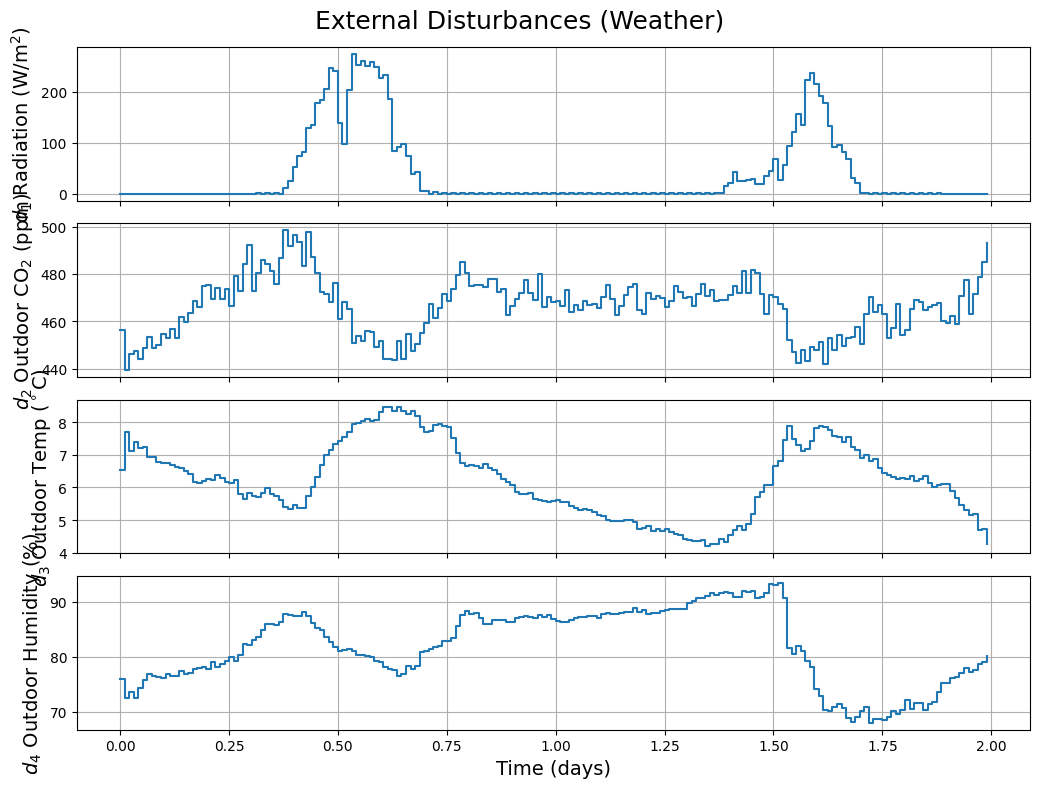

In [ ]:
###############################################################################
## LOAD MODEL PARAMETERS, DO NOT EDIT
###############################################################################
p = modelParameters()

###############################################################################
## DEFINE SIMULATION PARAMETERS
###############################################################################
# Define a dictionary 'ops' to hold simulation options and parameters
ops = {}
ops['nx'] = 4    # Number of states
ops['ny'] = 4    # Number of outputs
ops['nu'] = 3    # Number of controllable inputs
ops['nd'] = 4    # Number of disturbance inputs

# Simulation time parameters
c = 86400  # Seconds in a day
nDays = 2  # Number of days to simulate
ops['h'] = 15 * 60  # Sample period in seconds (15 minutes)
ops['L'] = nDays * c  # Total simulation time in seconds
ops['t'] = np.arange(0, ops['L'], ops['h'])  # Time vector
ops['N'] = len(ops['t'])  # Number of simulation steps
ops['N0'] = 0  # Start sample index for disturbance data. Change if you want to simulate at a different season.

ops['x0'] = np.array([0.0035, 1e-03, 15, 0.008])  # Initial state [dw, co2In, tempIn, vapIn]  

# bounds controls: u = [co2, vent, heat]
co2SupplyMin = 0             # lower bound on CO2 supply rate                
co2SupplyMax = 1.2           # upper bound on CO2 supply rate
ventMin = 0                  # lower bound on ventilation rate
ventMax = 7.5                # upper bound on ventilation rate
heatMin = 0                  # lower bound on energy input through heating
heatMax = 150                # upper bound on energy input through heating

# state constraints: x = [dw, co2In, tempIn, humIn]
WMin = 0                     # lower bound on dry weight     
WMax = float('inf')          # upper bound on dry weight      
co2Min = 0                   # lower bound on CO2 concentration
co2Max = 2.75e-3             # upper bound on CO2 concentration
tempMin = 6.5                # lower bound on temperature
tempMax = 40                 # upper bound on temperature
rhMin = 0                    # lower bound on relative humidity              
rhMax = 70                   # upper bound on relative humidity
ahMax = rh2vaporDens(tempMax,rhMax) # upper bound on vapor density 

# state constraints vector
ops['x_min']   = np.array([WMin, co2Min, tempMin, rhMin])
ops['x_max']   = np.array([WMax, co2Max, tempMax, ahMax])

# output constraints vector
ops['y_min']   = np.array([WMin, co2Min                          , tempMin, rhMin])
ops['y_max']   = np.array([WMax, 1e-3*co2dens2ppm(tempMax,co2Max), tempMax, rhMax])  

# control input constraints vector
ops['u_min']   = np.array([co2SupplyMin, ventMin, heatMin])
ops['u_max']   = np.array([co2SupplyMax, ventMax, heatMax])

y_limits = {
    1: {'min': ops['y_min'][1], 'max': ops['y_max'][1]},
    2: {'min': ops['y_min'][2], 'max': ops['y_max'][2]},
    3: {'min': ops['y_min'][3], 'max': ops['y_max'][3]},
}
u_limits = {
    0: {'min': ops['u_min'][0], 'max': ops['u_max'][0]},
    1: {'min': ops['u_min'][1], 'max': ops['u_max'][1]},
    2: {'min': ops['u_min'][2], 'max': ops['u_max'][2]},
}

###############################################################################
## LOAD DISTURBANCE (WEATHER) DATA, DO NOT EDIT
###############################################################################
d = loadDisturbances(ops)

# Plot the disturbance data
t_days = ops['t'][0:ops['N']] / 86400
fig, ax = plt.subplots(ops['nd'], 1, figsize=(10.5, 8), sharex=True)
fig.suptitle('External Disturbances (Weather)', fontsize=18)
# Convert disturbance units for plotting
d_plot = d.copy()
d_plot[1,:] = co2dens2ppm(d[2,:], d[1,:]) # CO2 to ppm
d_vaper     = vaporDens2rh(d[2,:], d[3,:]) # Vapor density to RH%
d_plot[3,:] = np.array(d_vaper).squeeze() # RH%
d_labels = [r'$d_1$ Radiation (W/m$^2$)', r'$d_2$ Outdoor CO$_2$ (ppm)', r'$d_3$ Outdoor Temp ($^\circ$C)', r'$d_4$ Outdoor Humidity (%)']
for i in range(ops['nd']):
    ax[i].plot(t_days, d_plot[i, 0:ops['N']], drawstyle='steps-post')
    ax[i].set_ylabel(d_labels[i], fontsize=14)
    ax[i].grid(True)

ax[-1].set_xlabel('Time (days)', fontsize=14)
plt.tight_layout()
plt.show()

## 3. Controller Design

### 3.1 Heuristic Feedforward Controller

To start, let's design a simple heuristic controller that adjusts heating and ventilation based on the current temperature and its setpoint. For example, heat if below setpoint, ventilate if above. Define the temperature setpoints for the entire simulation, with higher setpoint during daytime and lower setpoint otherwise:

The temperature setpoint switches depending on a daylight proxy $d_k^{(0)}$ (the first disturbance channel):
$
\text{sp\_temp}_k =
\begin{cases}
18, & d_k^{(0)} > 10 W/m^2, \\
12, & \text{otherwise}.
\end{cases}
$

 During the simulation loop, the heuristic controller compares the current temperature with the setpoint using a deadband rule:
- If the temperature is too low (below setpoint - deadband), maximum heating and minimum ventilation are applied 
- If the temperature is too high (above setpoint + deadband), maximum ventilation and minimum heating are applied
- CO₂ injection is kept constant throughout.  

Control actions are clipped to respect input limits, and the system dynamics are simulated forward in time using the given model functions.


In [ ]:
# Compute setpoints for the entire simulation
sp_temp_ff = np.zeros(ops['N'])
for k in range(ops['N']):
    sp_temp_ff[k] =  ##To be filled

# Simulate with heuristic controller
x = np.zeros((ops['nx'], ops['N'] + 1)) # initialize state array
y_ff = np.zeros((ops['ny'], ops['N']))  # initialize output array
u_ff = np.zeros((ops['nu'], ops['N']))  # initialize control input array
x[:, 0] = ops['x0']                            # Initial state
p = modelParameters()

for k in range(ops['N']):
    # TODO: Implement your heuristic controller here
    sp = sp_temp_ff[k]
    temp_current = x[2, k]  # Current temperature (x3)
    deadband = 1.0
    
    # heuristic control logic
    u_ff[:, k] = 0  # Default zero
    if temp_current < sp - deadband:
        ## To be filled
    elif temp_current > sp + deadband:
        ## To be filled
    
    u_ff[0, k] = 1  # Constant CO2 injection
    
    # Clip controls
    u_ff[:, k] = np.clip(u_ff[:, k], ops['u_min'], ops['u_max'])
    
    # Simulate next state
    # To be filled 
    x_casadi_next =  # next state in CasADi format
    y_casadi =  # output in CasADi format

    x[:, k+1] = np.array(x_casadi_next).squeeze() # convert to NumPy array and store
    y_ff[:, k] = np.array(y_casadi).squeeze() # convert to NumPy array and store

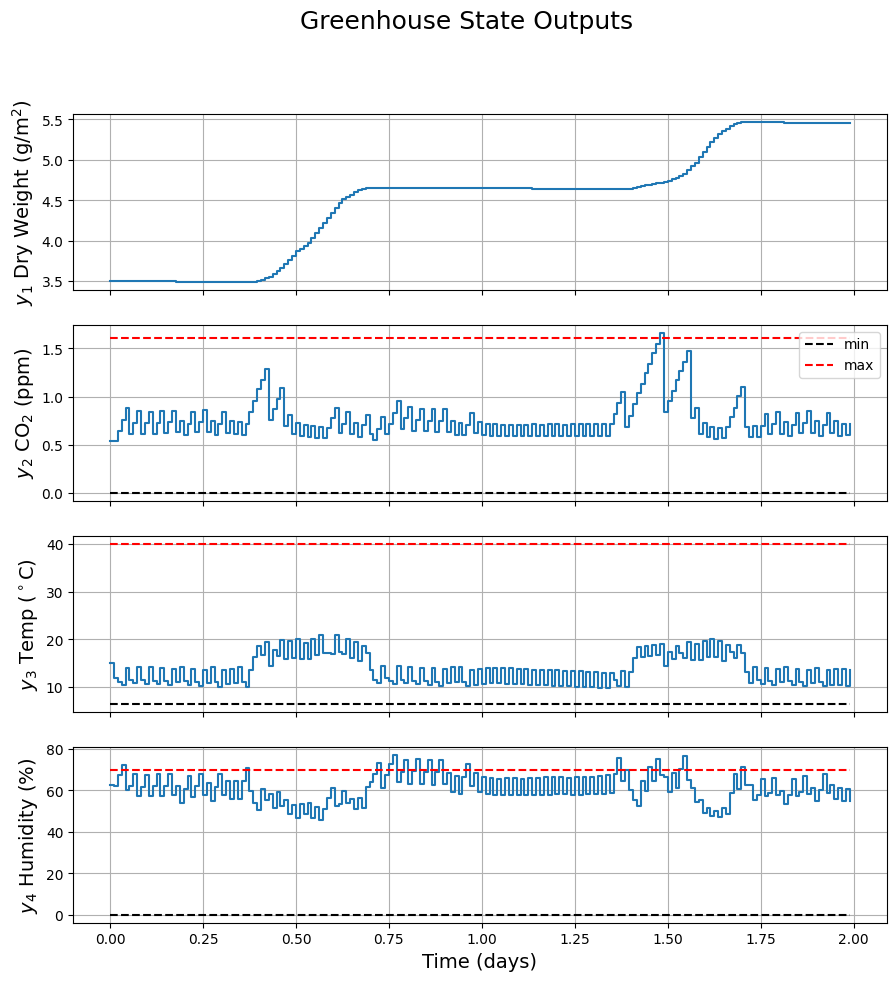

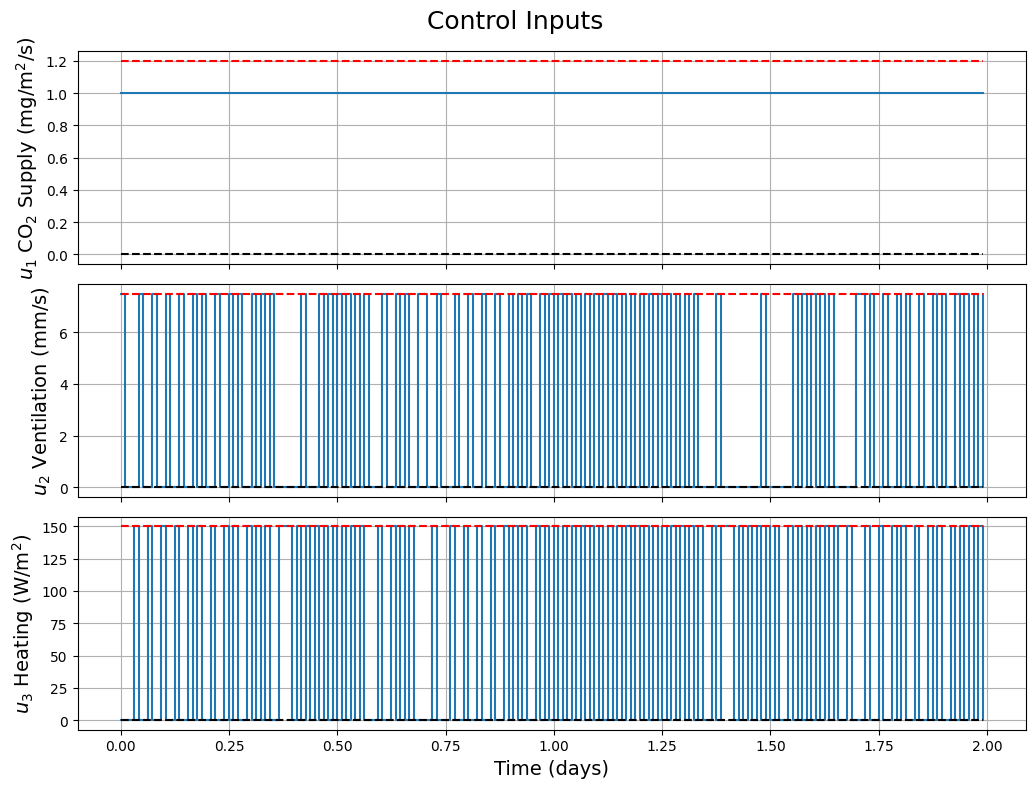

Mean Squared Error (Heuristic): 3.41
final dry weight (Heuristic): 5.45 g/m^2


In [289]:
# Plot heuristic results
plot_results(ops, y_ff, u_ff, d, y_lims=y_limits, u_lims=u_limits)

# Calculate and print Mean Squared Error for temperature tracking
mse_ff = np.mean((y_ff[2, :] - sp_temp_ff)**2)
print(f"Mean Squared Error (Heuristic): {mse_ff:.2f}")
print(f"final dry weight (Heuristic): {y_ff[0, -1]:.2f} g/m^2")

### 3.2 Nonlinear Model Predictive Controller (NMPC)

Now, implement the NMPC to control the climate of the greenhouse using `CasADi` and its embeded `IPOPT` solver. Set `Np` as the *prediction horizon*, and the temperature setpoints are used the same ones as before. Then the the objective is to minimize the tracking error for temperature over the prediction horizon.

#### Dynamics and outputs
The system is represented by the discrete-time model:
\begin{equation*}
X_{i+1} = f_d(X_i, U_i, d_i, p, h), \qquad
Y_i = g(X_i, U_i, d_i, p, h), \quad i = 0,\dots,N_p-1.
\end{equation*}

#### Objective function
At each stage $i$, the cost penalizes: (1) Deviation of the temperature output $Y_i^{(2)}$ from its setpoint. (2) Input magnitude (regularization) 
\begin{equation*}
\ell_i = (Y_i^{(2)} - \text{sp}_i)^2 - \lambda_1 (Y_i^{(0)})^2 + \lambda_2 \|U_i\|_2^2,
\qquad \lambda_1 = 0.1, \ \lambda_2 = 10^{-3},
\end{equation*}
where the second term is used to regulate the CO_2 injection by considering the yield, and the third term is to penalize input energy. This leads to the total cost:
$
J = \sum_{i=0}^{N_p-1} \ell_i.
$

#### Constraints
- Initial state:  $X_0 = x_0$
- Input bounds:
$
u_{\min} \le U_i \le u_{\max}.
$
- Output bounds (selected indices):
$
y_{\min}^{(1)} \le Y_i^{(1)} \le y_{\max}^{(1)}$,   $y_{\min}^{(2)} \le Y_i^{(2)} \le y_{\max}^{(2)}$,   $Y_i^{(3)} \le y_{\max}^{(3)}$.


#### Receding Horizon Simulation Loop
For each simulation step $k = 0,\dots,N-1$:

1. Build a disturbance horizon $[d_k, \dots, d_{k+N_p-1}]$. If fewer are available, pad by repeating the last value.  
2. Set parameters $x_0 \leftarrow x(k)$, $d_i \leftarrow D_k$.  
3. Solve the NMPC problem:
   \begin{equation*}
   U^*, X^*, Y^* = \arg\min J \;\;\text{s.t. dynamics + constraints.}
   \end{equation*}
4. Apply the first control $u(k) = U_0^*$.  
5. Simulate the next state and output:
   $
   x(k+1) = f_d(x(k), u(k), d(k), p, h), \
   y(k) = g(x(k), u(k), d(k), p, h).
   $
6. Record the setpoint at step $k$.

This process repeats, shifting the prediction horizon forward at each step.

In [ ]:
# NMPC parameters
ops['Np'] = 8  # Prediction horizon

# Initialize Opti environment for NMPC
opti = casadi.Opti()

# Define symbolic variables within Opti environment
X = opti.variable(ops['nx'], ops['Np'] + 1)  # State trajectory
U = opti.variable(ops['nu'], ops['Np'])      # Control inputs
Y = opti.variable(ops['ny'], ops['Np'])      # Outputs
x0_param = opti.parameter(ops['nx'])         # Initial state parameter
d_param = opti.parameter(ops['nd'], ops['Np'])  # Disturbance parameter

# Model parameters
p_sym = modelParameters()  # Numeric dictionary of parameters

# Objective
obj = 0 # Initialize objective function

# Set initial state constraint
opti.subject_to(X[:, 0] == x0_param) 

# Define dynamics and outputs over prediction horizon
for i in range(ops['Np']):
    u = U[:, i] # Control input at step i in CasADi format
    d_i = d_param[:, i] # Disturbance at step i in CasADi format

    # Next state in CasADi format
    x_next =  # To be filled
    # Output in CasADi format
    y =  
    
    # Store next state and output
    opti.subject_to(X[:, i+1] == x_next)
    opti.subject_to(Y[:, i] == y)
    
    # Compute setpoint
    sp_i = casadi.if_else(d_i[0] > 10, 18, 12) # Setpoint based on radiation
    
    # Compute objective function in CasADi format
    obj +=  # To be filled

# Add all the constraints on states and outputs
for i in range(ops['Np']):
    opti.subject_to(U[:, i] >= ops['u_min']) # Control lower bounds
    # To be filled

# Set up solver
opti.minimize(obj)   # Minimize the objective
opti.solver('ipopt') # Use IPOPT solver

# Simulate with NMPC
x = np.zeros((ops['nx'], ops['N'] + 1))
y_mpc = np.zeros((ops['ny'], ops['N']))
u_mpc = np.zeros((ops['nu'], ops['N']))
x[:, 0] = ops['x0']  # Use initial condition from simulation setup
sp_temp_mpc = np.ones(ops['N']) * 12

for k in range(ops['N']):
    # Disturbance over prediction horizon
    d_horizon = d[:, k:k+ops['Np']] 
    # If at the end of simulation, pad with last known disturbance
    if d_horizon.shape[1] < ops['Np']:
        d_horizon = np.hstack((d_horizon, np.tile(d_horizon[:, -1:], (1, ops['Np'] - d_horizon.shape[1]))))
    
    # Set parameters
    opti.set_value(x0_param, x[:, k])
    opti.set_value(d_param, d_horizon)
    
    # Solve the optimization problem
    sol =  # To be filled

    # Apply only the first control input
    u_mpc[:, k] =  # To be filled
    
    # Simulate next state
    # To be filled
    x_casadi_next =  # Next state in CasADi format
    y_casadi =  # Current output in CasADi format

    x[:, k+1] = np.array(x_casadi_next).squeeze() # Convert states to NumPy array and store
    y_mpc[:, k] = np.array(y_casadi).squeeze() # Convert outputs to NumPy array and store

    # Record setpoint
    sp_temp_mpc[k] = 18 if d[0, k] > 10 else 12

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      292
Number of nonzeros in inequality constraint Jacobian.:       88
Number of nonzeros in Lagrangian Hessian.............:      224

Total number of variables............................:       92
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       68
Total number of inequality constraints...............:       88
        inequality constraints with only lower bounds:       40
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       48

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1520000e+03 1.50e+01 2.40e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

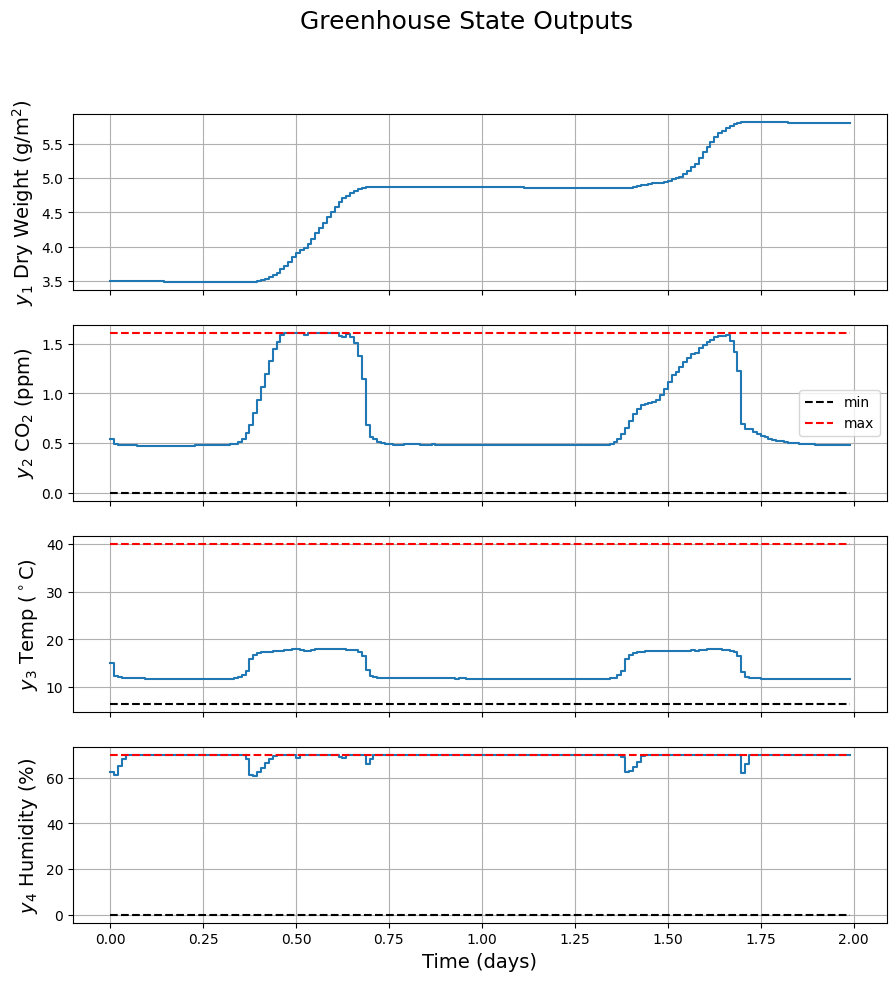

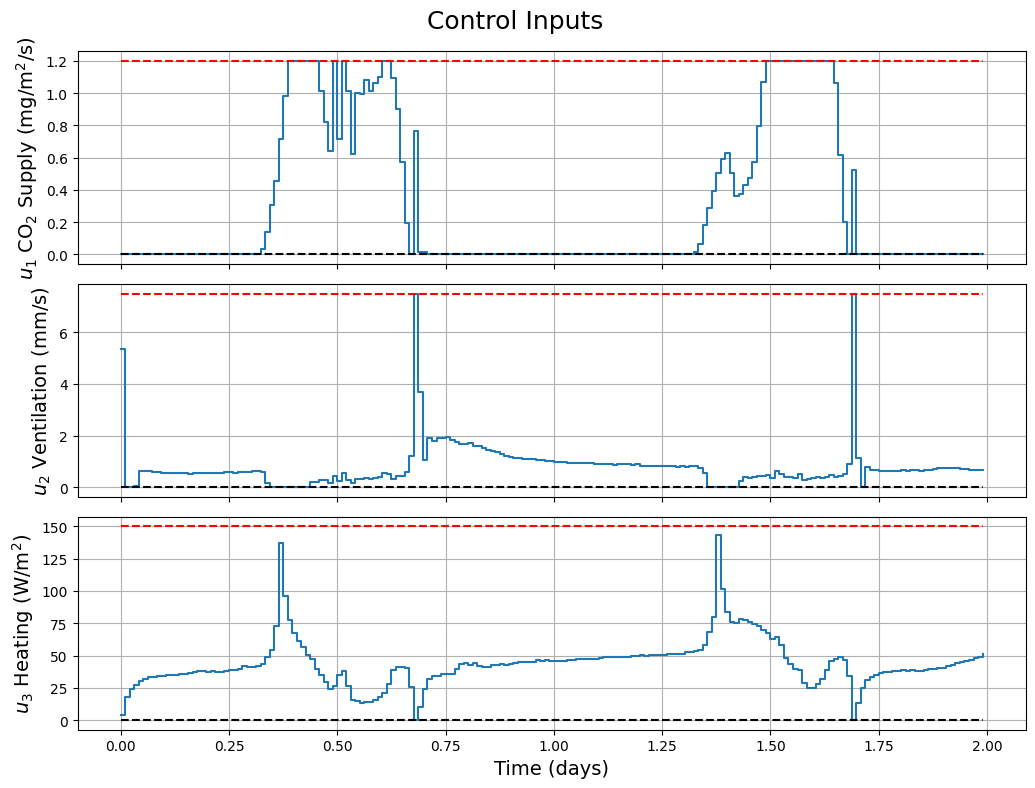

Mean Squared Error (NMPC): 0.25
final dry weight (Heuristic): 5.80 g/m^2


In [291]:
# Plot NMPC results
plot_results(ops, y_mpc, u_mpc, d, y_lims=y_limits, u_lims=u_limits)

mse_mpc = np.mean((y_mpc[2, :] - sp_temp_mpc)**2)
print(f"Mean Squared Error (NMPC): {mse_mpc:.2f}")
print(f"final dry weight (Heuristic): {y_mpc[0, -1]:.2f} g/m^2")

## 4. Comparison and Conclusion

Now, compare the results from the Heuristic controller (Part 1) and the NMPC controller (Part 2).

**Final Questions:**
1. **Performance:** Which controller achieved a lower mean squared error for temperature tracking? Which one was better at respecting the climate constraints (e.g., keeping humidity within the dashed lines)? Which one gives better crop yield?
2. **Efficiency:** Look at the control input plots. Which controller used more heating (`u_3`) or ventilation (`u_2`) overall?
3. **Behavior:** Describe the difference in the control actions. Describe the difference in the control actions. Are the NMPC's actions smoother or more aggressive? Does the NMPC seem to "anticipate" future events (like changes in solar radiation) based on the disturbance forecast?
4. **Complexity vs. Benefit:** The heuristic controller is much simpler to design and runs instantly. The NMPC is complex and computationally intensive. Based on your results, do you think the improved performance of NMPC justifies its complexity for this problem? 